In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch import nn, optim, Tensor
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.special import kl_div, rel_entr
import time
import random
import pickle

c:\Users\mbila\.conda\envs\CUDA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#setting which GPU to use
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'

In [3]:
#checking GPU status
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()
torch.cuda.current_device()
torch.cuda.device_count()

1

In [4]:
#setting hyperparameters
num_epochs = 2000 #epochs
learning_rate = 0.0001 #learning rate
gen_input_size = 256 #latent space
input_size = 1 # number of features (change to 1 for univariate data)
hidden_size = 128 #number of features in hidden state
num_layers = 3 #number of stacked lstm layers
num_classes = 1 #number of output classes
seq_length = 24*1 #sequence length
batch_size = 100 #batch size
dropout = 0.2 #dropout
discriminator_cycles = 3 #no of times the disctiminator runs more than the generator
n_labels = 1 #length of the label vector

In [5]:
# Loading the dataset from Huggingface
df = pd.read_csv("hf://datasets/vitaliy-sharandin/energy-consumption-hourly-spain/energy_dataset.csv")
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [6]:
# Convert the DataFrame into rows of 24 hourly values of solar production
df['hour'] = pd.to_datetime(df['time'], utc=True).dt.hour
df['day'] = pd.to_datetime(df['time'], utc=True).dt.date

reshaped_df = df.pivot(index='day', columns='hour', values='generation solar')
reshaped_df = reshaped_df.dropna()

reshaped_df.head()


hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day,,,,,,,,,,,,,,,,,,,,,
2015-01-01,50.0,50.0,50.0,42.0,34.0,34.0,35.0,54.0,743.0,2019.0,...,3818.0,3088.0,1467.0,404.0,139.0,100.0,75.0,74.0,56.0,54.0
2015-01-02,54.0,54.0,53.0,53.0,63.0,55.0,54.0,116.0,1039.0,2373.0,...,3619.0,3024.0,2053.0,769.0,266.0,165.0,137.0,137.0,137.0,62.0
2015-01-03,62.0,61.0,61.0,61.0,61.0,61.0,63.0,233.0,820.0,1665.0,...,3370.0,2692.0,1931.0,1015.0,502.0,355.0,291.0,207.0,117.0,692.0
2015-01-04,684.0,648.0,640.0,563.0,372.0,179.0,129.0,357.0,1634.0,3830.0,...,5593.0,5316.0,4907.0,4200.0,2911.0,1392.0,748.0,696.0,672.0,691.0
2015-01-06,624.0,616.0,582.0,576.0,499.0,415.0,412.0,1168.0,3018.0,4129.0,...,4641.0,4279.0,3824.0,3132.0,2383.0,1586.0,891.0,696.0,669.0,1280.0


In [7]:
# converting df to numpy
reshaped_df = reshaped_df.to_numpy()

# scaling the data
scaler = MinMaxScaler(feature_range=(-1, 1), copy=True)
data = scaler.fit_transform(reshaped_df)
print(max(data[:,0]))
print(min(data[:,0]))

#saving the scaler model
with open('model\scaler.pkl', 'wb') as fid:
    pickle.dump(scaler, fid)

0.9999999999999998
-1.0


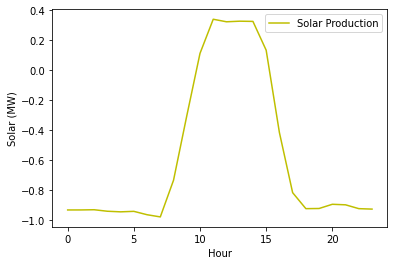

In [8]:
#plotting the scaled data
plt.figure()
plt.plot(data[0], 'y-', label='Solar Production')
plt.xlabel('Hour')
plt.ylabel('Solar (MW)')
plt.legend(loc="upper right", prop={'size': 10})
plt.show()

In [9]:
#making sequences of data of length equal to seq_length (24 hours)
data = data.reshape(-1, seq_length, input_size)
print(data.shape)

# Generating labels
labels = np.zeros((len(data), 1))

#shuffling the data before feeding it to the GAN
rng_state = np.random.get_state()
np.random.shuffle(data)
np.random.set_state(rng_state)
np.random.shuffle(labels)

labels = torch.Tensor(labels)
print(labels)

(1449, 24, 1)
tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]])


In [10]:
#making the dataloader
dataset = TensorDataset(Tensor(data), Tensor(labels))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
num_batches = len(data_loader)
print(num_batches)

15


In [11]:
#defining the discriminator
class DiscriminatorNet(torch.nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout, n_labels):
        super(DiscriminatorNet, self).__init__()
        
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        self.dropout = dropout #dropout ratio
        self.n_labels = n_labels #no of labels
        
        self.lstm = nn.LSTM(input_size=(input_size+n_labels), hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout = dropout)
        self.fc =  nn.Sequential(nn.Linear(hidden_size, num_classes), nn.Sigmoid())
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)  #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)  #internal state
        #Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and cell state
        hn = hn[-1,:,:] #reshaping the data for dense layer next
        out = self.fc(hn) #Final Output
        return out

In [12]:
#defining the generator
class GeneratorNet(torch.nn.Module):

    def __init__(self, num_classes, input_size, output_size, hidden_size, num_layers, seq_length, dropout, n_labels):
        super(GeneratorNet, self).__init__()
        
        n_out = output_size*seq_length
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        #self.dropout = dropout ratio
        self.n_labels = n_labels
        
        self.lstm = nn.LSTM(input_size=(input_size+n_labels), hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, dropout = dropout) #lstm

        self.fc =  nn.Sequential(nn.Linear(hidden_size, n_out), nn.Tanh())

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)  #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)  #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn[-1,:,:] #reshaping the data for dense layer next
        out = self.fc(hn) #Final Output
        return out

In [13]:
#Function for geneting noise
def noise(size):
    n = Variable(torch.randn(size, seq_length, gen_input_size))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [14]:
#initializing the generator and the discriminator
discriminator = DiscriminatorNet(num_classes, input_size, hidden_size, num_layers, seq_length, dropout, n_labels)
generator = GeneratorNet(num_classes, gen_input_size, input_size, hidden_size, num_layers, seq_length, dropout, n_labels)
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()
    
print(discriminator)
print()
print(generator)

DiscriminatorNet(
  (lstm): LSTM(2, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

GeneratorNet(
  (lstm): LSTM(257, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=24, bias=True)
    (1): Tanh()
  )
)


In [15]:
#Initializing the optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr= learning_rate)
g_optimizer = optim.Adam(generator.parameters(), lr= learning_rate)

# Initializing the loss function
loss = nn.BCELoss()

In [16]:
#functions for generating the real and fake data targets to compute the loss against
def real_data_target(size):

    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):

    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [17]:
#defining the discriminator train cycle
def train_discriminator(optimizer, real_data, fake_data):
    #Reset gradients
    optimizer.zero_grad()
    
    #Train on Real Data
    prediction_real = discriminator(real_data)
    #Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    #Train on Fake Data
    prediction_fake = discriminator(fake_data)
    #Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    #Update weights with gradients
    optimizer.step()
    
    #Return error
    return error_real + error_fake, prediction_real, prediction_fake

#defining the generator train cycle
def train_generator(optimizer, fake_data):
    #Reset gradients
    optimizer.zero_grad()
    #Sample noise and generate fake data
    prediction = discriminator(fake_data)
    #Calculate error and backpropagate
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    #Update weights with gradients
    optimizer.step()
    #Return error
    return error

In [20]:
#main training code
start = time.time() #keeping track of training time
for epoch in range(num_epochs):
    
    for n_batch, (real_batch, real_label) in enumerate(data_loader):
        
        if torch.cuda.is_available(): real_data = real_batch.cuda()
        else: real_data = Variable(real_batch).float()
        if torch.cuda.is_available(): real_label = (real_label.unsqueeze(1) * torch.ones([real_data.size(0),
                                                                                            seq_length, n_labels])).cuda()
        else: real_label = Variable(real_label.unsqueeze(1) * torch.ones([real_data.size(0),
                                                                                            seq_length, n_labels])).float()
        real_data = torch.cat([real_data, real_label], dim = 2).cuda()
        
        #Training Discriminator
        for _ in range(discriminator_cycles):
            #Generating fake data
            fake_data = generator(torch.cat([noise(real_data.size(0)), real_label], dim = 2))
            fake_data = torch.reshape(fake_data ,(-1, seq_length, input_size)).to(device)
            fake_data = torch.cat([fake_data, real_label], dim = 2)
            
            d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                    real_data, fake_data)

        #Training Generator
        #Generating fake data
        fake_data = generator(torch.cat([noise(real_data.size(0)), real_label], dim = 2))
        fake_data = torch.reshape(fake_data ,(-1, seq_length, input_size)).to(device)
        fake_data = torch.cat([fake_data, real_label], dim = 2)
        
        g_error = train_generator(g_optimizer, fake_data)
        
    print("Epoch: %d, discriminator loss: %1.5f, generator loss: %1.5f" % (epoch, d_error, g_error))
end = time.time()
print(f"Runtime of the program is {end - start} seconds")

Epoch: 0, discriminator loss: 1.37586, generator loss: 0.68697
Epoch: 1, discriminator loss: 0.87288, generator loss: 0.97048
Epoch: 2, discriminator loss: 0.40507, generator loss: 2.00127
Epoch: 3, discriminator loss: 0.44213, generator loss: 2.32438
Epoch: 4, discriminator loss: 0.38902, generator loss: 2.18999
Epoch: 5, discriminator loss: 0.38645, generator loss: 2.18539
Epoch: 6, discriminator loss: 0.34525, generator loss: 1.95384
Epoch: 7, discriminator loss: 0.61878, generator loss: 1.90158
Epoch: 8, discriminator loss: 0.60154, generator loss: 1.95152
Epoch: 9, discriminator loss: 0.66273, generator loss: 2.10382
Epoch: 10, discriminator loss: 0.67172, generator loss: 2.38938
Epoch: 11, discriminator loss: 0.91504, generator loss: 1.27887
Epoch: 12, discriminator loss: 0.59582, generator loss: 2.00367
Epoch: 13, discriminator loss: 0.41300, generator loss: 2.31353
Epoch: 14, discriminator loss: 0.32090, generator loss: 2.93324
Epoch: 15, discriminator loss: 0.23427, generator 

In [21]:
#runtime in minutes
runtime = (end-start)/60
print("Training took ",round(runtime), " minutes")

# Saving generator weights
torch.save(generator, "model/generator_weights.pth")

Training took  63  minutes


In [23]:
# # #loading generator model
# generator = torch.load("model/generator_weights.pth")

# # #loading scaler model
# with open('model/scaler.pkl', 'rb') as fid:
#     scaler = pickle.load(fid)

10
tensor([0.])
(10, 24, 1)


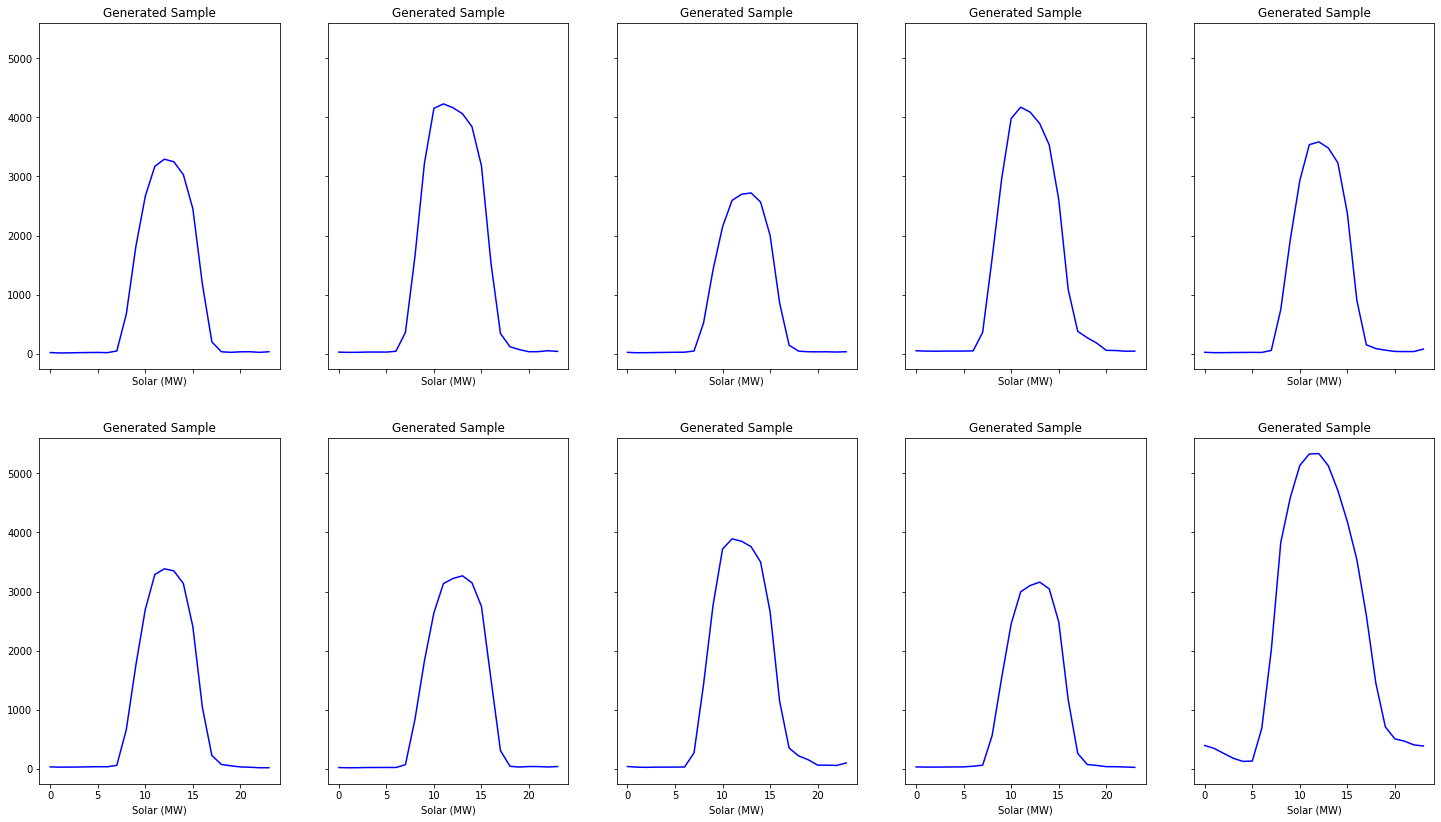

In [22]:
# generating samples from trained generator and plotting the results

# gnerating labels for the required season to be plotted
sample_labels = [0]
sample_count = 10
sample_labels = torch.Tensor(np.tile(sample_labels, (sample_count, 1)))
print(len(sample_labels))
print(sample_labels[0])

sample_labels = (sample_labels.unsqueeze(1) * torch.ones([sample_count, seq_length, n_labels])).cuda()

generator.eval()

#generating samples from the generator
with torch.no_grad():
    sample = generator(torch.cat([noise(sample_count), sample_labels], dim = 2)).reshape(-1, seq_length, input_size).detach()
    sample = sample.cpu().numpy()
    print(sample.shape)

# plotting the generated data
fig, axes = plt.subplots(figsize=(25,14), nrows=2, ncols=5, sharey=True, sharex=True)

for ax, img in zip(axes.flatten(), sample):
    img = scaler.inverse_transform(np.transpose(img))
    ax.plot(img[0,], 'b-', label='Generated')
    # ax.set_ylim([0, 7000])
    ax.set_xlabel('Solar (MW)')
    ax.set_title('Generated Sample')
    
plt.show()